In [5]:
import cv2
from PIL import ImageOps
import numpy as np
import tensorflow as tf
import pandas as pd 
from keras.utils.np_utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout,MaxPool2D,Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix,accuracy_score
import time
#from keras.models import model_from_json
import os

# Data

In [6]:
## Read in Dataset
dataTrain = pd.read_csv("sign_mnist_train.csv")
dataTest = pd.read_csv("sign_mnist_test.csv")

yTrain, yTest = dataTrain["label"], dataTest["label"]
yTrain = to_categorical(yTrain, num_classes = 25)
yTest = to_categorical(yTest, num_classes = 25)

dataTrain.drop("label",axis=1,inplace=True)
dataTest.drop("label",axis=1,inplace=True)

In [7]:
## Normalize Data and reshape data
xTrain, xTest = dataTrain.values, dataTest.values
xTrain = xTrain.reshape(-1,28,28,1)
xTest = xTest.reshape(-1,28,28,1)
xTrain = xTrain/255
xTest = xTest/255
xTrain, xDev, yTrain, yDev = train_test_split(xTrain,yTrain,test_size=0.2,random_state=1)

In [8]:
## Data Augmentation
trainData = ImageDataGenerator(
    rotation_range = 45,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    horizontal_flip = True
)

# Model 

In [9]:
## Model generation
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = "Same", activation = "relu", input_shape = (28,28,1)))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "Same", activation = "relu"))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "Same", activation = "relu"))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(25,activation="softmax"))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

# Training

In [12]:
## Model Compile

model.compile(optimizer="adam", loss ="categorical_crossentropy", metrics = ["accuracy"])
epochs = 10
batchSize = 256
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit_generator(generator = trainData.flow(xTrain,yTrain,batch_size = batchSize), 
                              epochs = epochs, 
                              validation_data=(xDev,yDev), 
                              callbacks=[cp_callback])

Epoch 1/10
85/86 [============================>.] - ETA: 0s - loss: 3.0221 - accuracy: 0.0925
Epoch 00001: saving model to training/cp.ckpt
86/86 [==============================] - 46s 539ms/step - loss: 3.0184 - accuracy: 0.0934 - val_loss: 2.4279 - val_accuracy: 0.2415
Epoch 2/10
85/86 [============================>.] - ETA: 0s - loss: 2.2772 - accuracy: 0.2705
Epoch 00002: saving model to training/cp.ckpt
86/86 [==============================] - 40s 464ms/step - loss: 2.2742 - accuracy: 0.2717 - val_loss: 1.5516 - val_accuracy: 0.5290
Epoch 3/10
85/86 [============================>.] - ETA: 0s - loss: 1.7612 - accuracy: 0.4210
Epoch 00003: saving model to training/cp.ckpt
86/86 [==============================] - 41s 478ms/step - loss: 1.7586 - accuracy: 0.4223 - val_loss: 1.0845 - val_accuracy: 0.6682
Epoch 4/10
85/86 [============================>.] - ETA: 0s - loss: 1.4097 - accuracy: 0.5316
Epoch 00004: saving model to training/cp.ckpt
86/86 [==============================] - 44s

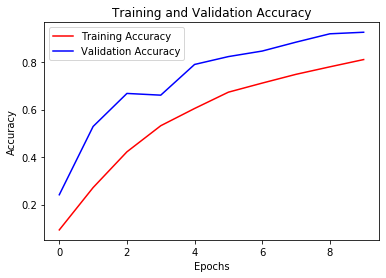

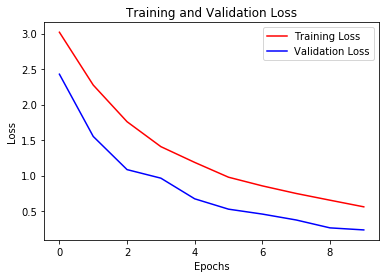

In [13]:
# Plots

trainAcc, valAcc = history.history["accuracy"], history.history["val_accuracy"]
trainLoss, valLoss = history.history["loss"], history.history["val_loss"]

plt.plot(range(epochs),trainAcc,"r",label="Training Accuracy")
plt.plot(range(epochs),valAcc,"b",label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(range(epochs),trainLoss,"r",label="Training Loss")
plt.plot(range(epochs),valLoss,"b",label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Testing

In [15]:
## Load Model
if os.path.exists("training/checkpoint"):
    model.load_weights(checkpoint_path)
else:
    raise Exception("No Weights Found.")

In [16]:
## Prediction
preds = model.predict_classes(xTest)
yTest = np.argmax(yTest,1)
confusionMatrix = confusion_matrix(yTest,preds)

Accuracy Of Test Data: 0.8531790295593976


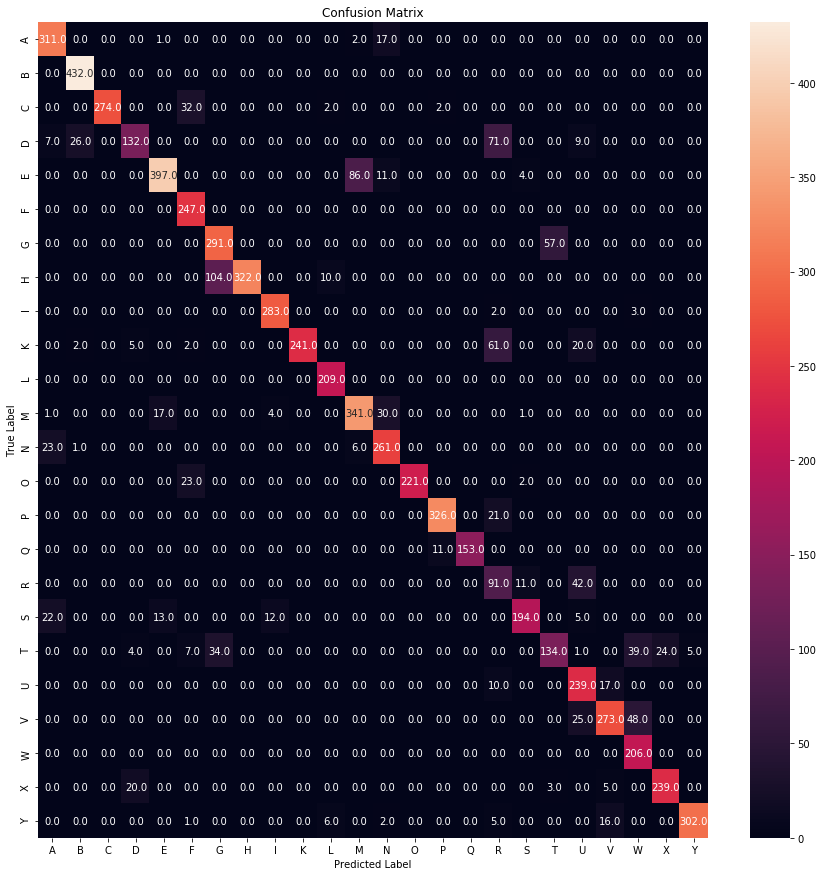

In [17]:
print("Accuracy Of Test Data: {}".format(accuracy_score(yTest,preds)))

classes = ["A","B","C","D","E","F","G","H","I","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y"]
_, ax = plt.subplots(figsize=(15,15))
heatmap = sn.heatmap(confusionMatrix, annot=True, fmt= '.1f',ax=ax)
heatmap.yaxis.set_ticklabels(classes)
heatmap.xaxis.set_ticklabels(classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# LIVE

In [53]:
cam = cv2.VideoCapture(0)
backSub = cv2.createBackgroundSubtractorMOG2() 

sentence = ""

count = 0

while(True):
    time.sleep(0.2)
    
    ret, frame = cam.read()
    if not ret: continue

    gray = backSub.apply(frame)  # Subtract Background
    
    imageResized = cv2.resize(gray, (28,28))
    imageResized = np.expand_dims(imageResized,0)
    imageResized = np.expand_dims(imageResized,3)
    imageResized = np.asarray(imageResized, dtype=np.float32)/255
    
    
    predictions = model.predict(imageResized)[0]
    idx = np.argmax(predictions)
    score = predictions[idx]
    if score > 0.999:
        cv2.imshow('Camera',frame)
        sentence+=classes[idx]
        time.sleep(2)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        

print("YOUR SENTENCE WAS: {}".format(sentence))      
cam.release()
cv2.destroyAllWindows()


YOUR SENTENCE WAS: RL
